# Credit Risk Modeling: Data Preparation


### 1.1 Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 1.2 Import Data

In [2]:
loan_data_backup = pd.read_csv('/content/loan_data_2007_2014.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/loan_data_2007_2014.csv'

In [ ]:
loan_data = loan_data_backup.copy()

### 1.3 Explore Data

In [ ]:
loan_data.head(5)

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

# The target variable

In [ ]:
loan_data['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [ ]:
loan_data['loan_status'].value_counts() / loan_data['loan_status'].count()

,count
loan_status,
Current,0.480878
Fully Paid,0.396193
Charged Off,0.091092
Late (31-120 days),0.014798
In Grace Period,0.006747
Does not meet the credit policy. Status:Fully Paid,0.004263
Late (16-30 days),0.002612
Default,0.001784
Does not meet the credit policy. Status:Charged Off,0.001632


In [ ]:
loan_data['status'] = \
np.where(loan_data['loan_status'].\
         isin(['Charged Off', 'Default',
               'Does not meet the credit policy. Status:Charged Off',
               'Late (31-120 days)']), 0, 1)
#create a new variable that has the value of '0' if a condition is met,
# and the value of '1' if it is no
loan_data.drop(columns=['loan_status'], inplace=True)

# Check the data types




In [ ]:
loan_data.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

In [ ]:
int_columns = loan_data.select_dtypes("int64")
float_columns = loan_data.select_dtypes("float64")
obj_columns = loan_data.select_dtypes("O")

## Processing columns of type `int`




In [ ]:
int_columns.head(5)

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,revol_bal,policy_code,status
0,0,1077501,1296599,5000,5000,13648,1,1
1,1,1077430,1314167,2500,2500,1687,1,0
2,2,1077175,1313524,2400,2400,2956,1,1
3,3,1076863,1277178,10000,10000,5598,1,1
4,4,1075358,1311748,3000,3000,27783,1,1


In [ ]:
int_columns.policy_code.unique()

array([1])

We drop irrelevant columns, and we change the type of the amounts from int64 to float64.

In [ ]:
int_columns.drop(columns=['Unnamed: 0', 'id', 'member_id', 'policy_code'], inplace=True)
int_columns[['loan_amnt', 'funded_amnt', 'revol_bal']] =\
 int_columns[['loan_amnt', 'funded_amnt', 'revol_bal']].astype('float64')

In [ ]:
int_columns.head(5)

,loan_amnt,funded_amnt,revol_bal,status
0,5000.0,5000.0,13648.0,1
1,2500.0,2500.0,1687.0,0
2,2400.0,2400.0,2956.0,1
3,10000.0,10000.0,5598.0,1
4,3000.0,3000.0,27783.0,1


In [ ]:
int_columns.isnull().sum()

,0
loan_amnt,0
funded_amnt,0
revol_bal,0
status,0


## Processing columns of type `Object`




In [ ]:
obj_columns.head(5)

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,pymnt_plan,url,...,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type
0,36 months,B,B2,NaN,10+ years,RENT,Verified,Dec-11,n,https://www.lendingclub.com/browse/loanDetail....,...,credit_card,Computer,860xx,AZ,Jan-85,f,Jan-15,NaN,Jan-16,INDIVIDUAL
1,60 months,C,C4,Ryder,< 1 year,RENT,Source Verified,Dec-11,n,https://www.lendingclub.com/browse/loanDetail....,...,car,bike,309xx,GA,Apr-99,f,Apr-13,NaN,Sep-13,INDIVIDUAL
2,36 months,C,C5,NaN,10+ years,RENT,Not Verified,Dec-11,n,https://www.lendingclub.com/browse/loanDetail....,...,small_business,real estate business,606xx,IL,Nov-01,f,Jun-14,NaN,Jan-16,INDIVIDUAL
3,36 months,C,C1,AIR RESOURCES BOARD,10+ years,RENT,Source Verified,Dec-11,n,https://www.lendingclub.com/browse/loanDetail....,...,other,personel,917xx,CA,Feb-96,f,Jan-15,NaN,Jan-15,INDIVIDUAL
4,60 months,B,B5,University Medical Group,1 year,RENT,Source Verified,Dec-11,n,https://www.lendingclub.com/browse/loanDetail....,...,other,Personal,972xx,OR,Jan-96,f,Jan-16,Feb-16,Jan-16,INDIVIDUAL


In [ ]:
obj_columns.columns.values

array(['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'pymnt_plan',
       'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'next_pymnt_d', 'last_credit_pull_d', 'application_type'],
      dtype=object)

In [ ]:
obj_columns.emp_title.unique().shape

(205476,)

In [ ]:
obj_columns.loc[:, obj_columns.nunique() == 2].columns

Index(['term', 'pymnt_plan', 'initial_list_status'], dtype='object')

In [ ]:
irrelevant = ['url', 'title', 'application_type', 'desc', 'emp_title', 'next_pymnt_d']
binary = ['term', 'pymnt_plan', 'initial_list_status']
dates = ['issue_d', 'earliest_cr_line', 'last_credit_pull_d', 'last_pymnt_d']
categorical = ['addr_state', 'zip_code', 'purpose',\
            'verification_status', 'home_ownership',\
            'sub_grade', 'grade']
numerical = ['emp_length']

### Drop irrelevant

In [ ]:
obj_columns.drop(columns=irrelevant, inplace=True)

### Cast dates columns into the correct format

In [ ]:
for date in dates:
    obj_columns[date] = pd.to_datetime(obj_columns[date], format='%b-%y')

obj_columns[dates]

,issue_d,earliest_cr_line,last_credit_pull_d,last_pymnt_d
0,2011-12-01,1985-01-01,2016-01-01,2015-01-01
1,2011-12-01,1999-04-01,2013-09-01,2013-04-01
2,2011-12-01,2001-11-01,2016-01-01,2014-06-01
3,2011-12-01,1996-02-01,2015-01-01,2015-01-01
4,2011-12-01,1996-01-01,2016-01-01,2016-01-01
...,...,...,...,...
466280,2014-01-01,2003-04-01,2016-01-01,2016-01-01
466281,2014-01-01,1997-06-01,2016-01-01,2014-12-01
466282,2014-01-01,2001-12-01,2015-12-01,2016-01-01
466283,2014-01-01,2003-02-01,2015-04-01,2014-12-01


In [ ]:
reference_date = pd.to_datetime('2017-12-01')
for date in dates:
    obj_columns[date] = reference_date - obj_columns[date]
    obj_columns[date] = obj_columns[date].astype('str').str.replace('NaT', 'NaN')
    obj_columns[date] = obj_columns[date].astype('str').str.replace(' days', '')
    obj_columns[date] = obj_columns[date].astype('float64')/30.5

In [ ]:
obj_columns[dates].isnull().sum()

,0
issue_d,0
earliest_cr_line,29
last_credit_pull_d,42
last_pymnt_d,376


In [ ]:
obj_columns['earliest_cr_line'].fillna(0, inplace=True)
obj_columns.drop(columns=['last_credit_pull_d', 'last_pymnt_d'], inplace=True)

### Numerical

In [ ]:
obj_columns.emp_length.unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [ ]:
obj_columns['emp_length_int'] = \
obj_columns['emp_length'].str.replace('+ years', '')
obj_columns['emp_length_int'] = \
obj_columns['emp_length_int'].str.replace('< 1 year', str(0))
obj_columns['emp_length_int'] = \
obj_columns['emp_length_int'].str.replace('n/a',  str(0))
obj_columns['emp_length_int'] = \
obj_columns['emp_length_int'].str.replace(' years', '')
obj_columns['emp_length_int'] = \
obj_columns['emp_length_int'].str.replace(' year', '')

Drop `emp_length`

In [ ]:
obj_columns.drop(columns=['emp_length'], inplace=True)

In [ ]:
obj_columns['emp_length_int'] = pd.to_numeric(obj_columns['emp_length_int'])
# Transforms the values to numeric.

In [ ]:
obj_columns['emp_length_int'].fillna(0, inplace=True)

In [ ]:
obj_columns.isnull().sum()

,0
term,0
grade,0
sub_grade,0
home_ownership,0
verification_status,0
issue_d,0
pymnt_plan,0
purpose,0
zip_code,0
addr_state,0


### Binary

In [ ]:
obj_columns['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [ ]:
obj_columns['pymnt_plan'].unique()

array(['n', 'y'], dtype=object)

In [ ]:
obj_columns['initial_list_status'].unique()

array(['f', 'w'], dtype=object)

In [ ]:
obj_columns['isThreeYearsTerm'] = obj_columns['term'].map({' 36 months': 1, ' 60 months': 0})
obj_columns['Payment_Plan'] = obj_columns['pymnt_plan'].map({'y': 1, 'n': 0})
obj_columns['Initial_Status'] = obj_columns['initial_list_status'].map({'w': 1, 'f': 0})
obj_columns.drop(columns=binary, inplace=True)

### Categorical

In [ ]:
categorical

['addr_state',
 'zip_code',
 'purpose',
 'verification_status',
 'home_ownership',
 'sub_grade',
 'grade']

In [ ]:
obj_columns[categorical]

,addr_state,zip_code,purpose,verification_status,home_ownership,sub_grade,grade
0,AZ,860xx,credit_card,Verified,RENT,B2,B
1,GA,309xx,car,Source Verified,RENT,C4,C
2,IL,606xx,small_business,Not Verified,RENT,C5,C
3,CA,917xx,other,Source Verified,RENT,C1,C
4,OR,972xx,other,Source Verified,RENT,B5,B
...,...,...,...,...,...,...,...
466280,TX,773xx,debt_consolidation,Source Verified,MORTGAGE,C2,C
466281,TN,377xx,debt_consolidation,Verified,MORTGAGE,D5,D
466282,OH,458xx,debt_consolidation,Verified,MORTGAGE,D1,D
466283,CA,913xx,credit_card,Verified,OWN,A4,A


## Processing columns of type `float`




In [ ]:
float_columns.columns.values

array(['funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_util',
       'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint',
       'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m',
       'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util',
       'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m'],
      dtype=object)

In [ ]:
float_columns.inq_last_12m.unique()

array([nan])

In [ ]:
irrelevant_float = []
for col in float_columns.columns.values:
    if len(float_columns[col].unique())==1:
        irrelevant_float.append(col)

irrelevant_float

['annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'open_acc_6m',
 'open_il_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m']

In [ ]:
float_columns.drop(columns=irrelevant_float, inplace=True)
float_columns.head(5)

,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,4975.0,10.65,162.87,24000.0,27.65,0.0,1.0,NaN,NaN,3.0,...,0.00,0.00,0.00,171.62,0.0,NaN,0.0,NaN,NaN,NaN
1,2500.0,15.27,59.83,30000.0,1.00,0.0,5.0,NaN,NaN,3.0,...,0.00,117.08,1.11,119.66,0.0,NaN,0.0,NaN,NaN,NaN
2,2400.0,15.96,84.33,12252.0,8.72,0.0,2.0,NaN,NaN,2.0,...,0.00,0.00,0.00,649.91,0.0,NaN,0.0,NaN,NaN,NaN
3,10000.0,13.49,339.31,49200.0,20.00,0.0,1.0,35.0,NaN,10.0,...,16.97,0.00,0.00,357.48,0.0,NaN,0.0,NaN,NaN,NaN
4,3000.0,12.69,67.79,80000.0,17.94,0.0,0.0,38.0,NaN,15.0,...,0.00,0.00,0.00,67.79,0.0,NaN,0.0,NaN,NaN,NaN


### deal with missing values

In [ ]:
float_columns.columns[float_columns.isnull().any()].values

array(['annual_inc', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_util', 'total_acc', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim'], dtype=object)

In [ ]:
float_columns.isnull().sum()[float_columns.isnull().sum()>0]

,0
annual_inc,4
delinq_2yrs,29
inq_last_6mths,29
mths_since_last_delinq,250351
mths_since_last_record,403647
open_acc,29
pub_rec,29
revol_util,340
total_acc,29
collections_12_mths_ex_med,145


In [ ]:
cols_to_inverse = ['mths_since_last_delinq',\
                   'mths_since_last_record',\
                   'mths_since_last_major_derog']

for col in cols_to_inverse:
    float_columns[col] = 1 / float_columns[col]
    float_columns[col].fillna(0, inplace=True)

In [ ]:
# float_columns['annual_inc'].fillna(float_columns['annual_inc'].mean(), inplace=True)

In [ ]:
float_columns['total_rev_hi_lim'].fillna(0, inplace=True)
float_columns['tot_coll_amt'].fillna(0, inplace=True)
float_columns['acc_now_delinq'].fillna(0, inplace=True)
float_columns['total_acc'].fillna(0, inplace=True)
float_columns['pub_rec'].fillna(0, inplace=True)
float_columns['open_acc'].fillna(0, inplace=True)
float_columns['inq_last_6mths'].fillna(0, inplace=True)
float_columns['delinq_2yrs'].fillna(0, inplace=True)
float_columns['collections_12_mths_ex_med'].fillna(0, inplace=True)
float_columns['tot_cur_bal'].fillna(0, inplace=True)
float_columns['revol_util'].fillna(0, inplace=True)

In [ ]:
float_columns.isnull().sum().sum()

0

In [ ]:
df = pd.concat([int_columns, float_columns, obj_columns], axis=1)

# Calculate mean income by state
mean_income_by_state = df.groupby('addr_state')['annual_inc'].mean()

# Define a function to fill NaN values with the state mean
def fill_na_with_state_mean(row):
    if pd.isna(row['annual_inc']):
        return mean_income_by_state[row['addr_state']]
    return row['annual_inc']

# Apply the function to fill NaN values in the 'annual_inc' column
df['annual_inc'] = df.apply(fill_na_with_state_mean, axis=1)

,loan_amnt,funded_amnt,revol_bal,status,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,verification_status,issue_d,purpose,zip_code,addr_state,earliest_cr_line,emp_length_int,isThreeYearsTerm,Payment_Plan,Initial_Status
0,5000.0,5000.0,13648.0,1,4975.0,10.65,162.87,24000.0,27.65,0.0,...,Verified,71.868852,credit_card,860xx,AZ,394.163934,10.0,1,0,0
1,2500.0,2500.0,1687.0,0,2500.0,15.27,59.83,30000.0,1.00,0.0,...,Source Verified,71.868852,car,309xx,GA,223.573770,0.0,0,0,0
2,2400.0,2400.0,2956.0,1,2400.0,15.96,84.33,12252.0,8.72,0.0,...,Not Verified,71.868852,small_business,606xx,IL,192.590164,10.0,1,0,0
3,10000.0,10000.0,5598.0,1,10000.0,13.49,339.31,49200.0,20.00,0.0,...,Source Verified,71.868852,other,917xx,CA,261.442623,10.0,1,0,0
4,3000.0,3000.0,27783.0,1,3000.0,12.69,67.79,80000.0,17.94,0.0,...,Source Verified,71.868852,other,972xx,OR,262.459016,1.0,0,0,0


In [4]:
df.to_csv('cleaned_loan_data_2007-2014.csv', index=False)
df[df['status']==0].to_csv('cleaned_loan_data_2007-2014_defaults.csv', index=False)
df.head(5)

,loan_amnt,funded_amnt,revol_bal,status,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,verification_status,issue_d,purpose,zip_code,addr_state,earliest_cr_line,emp_length_int,isThreeYearsTerm,Payment_Plan,Initial_Status
0,5000.0,5000.0,13648.0,1,4975.0,10.65,162.87,24000.0,27.65,0.0,...,Verified,71.868852,credit_card,860xx,AZ,394.163934,10.0,1,0,0
1,2500.0,2500.0,1687.0,0,2500.0,15.27,59.83,30000.0,1.00,0.0,...,Source Verified,71.868852,car,309xx,GA,223.573770,0.0,0,0,0
2,2400.0,2400.0,2956.0,1,2400.0,15.96,84.33,12252.0,8.72,0.0,...,Not Verified,71.868852,small_business,606xx,IL,192.590164,10.0,1,0,0
3,10000.0,10000.0,5598.0,1,10000.0,13.49,339.31,49200.0,20.00,0.0,...,Source Verified,71.868852,other,917xx,CA,261.442623,10.0,1,0,0
4,3000.0,3000.0,27783.0,1,3000.0,12.69,67.79,80000.0,17.94,0.0,...,Source Verified,71.868852,other,972xx,OR,262.459016,1.0,0,0,0


# Load Cleaned Data from the Disk

In [3]:
df = pd.read_csv('/content/cleaned_loan_data_2007-2014.csv')
df.head(5)

,loan_amnt,funded_amnt,revol_bal,status,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,verification_status,issue_d,purpose,zip_code,addr_state,earliest_cr_line,emp_length_int,isThreeYearsTerm,Payment_Plan,Initial_Status
0,5000.0,5000.0,13648.0,1,4975.0,10.65,162.87,24000.0,27.65,0.0,...,Verified,71.868852,credit_card,860xx,AZ,394.163934,10.0,1,0,0
1,2500.0,2500.0,1687.0,0,2500.0,15.27,59.83,30000.0,1.00,0.0,...,Source Verified,71.868852,car,309xx,GA,223.573770,0.0,0,0,0
2,2400.0,2400.0,2956.0,1,2400.0,15.96,84.33,12252.0,8.72,0.0,...,Not Verified,71.868852,small_business,606xx,IL,192.590164,10.0,1,0,0
3,10000.0,10000.0,5598.0,1,10000.0,13.49,339.31,49200.0,20.00,0.0,...,Source Verified,71.868852,other,917xx,CA,261.442623,10.0,1,0,0
4,3000.0,3000.0,27783.0,1,3000.0,12.69,67.79,80000.0,17.94,0.0,...,Source Verified,71.868852,other,972xx,OR,262.459016,1.0,0,0,0


# Categorical Encoding

In [ ]:
categorical = df.select_dtypes('O').columns.values
categorical

array(['grade', 'sub_grade', 'home_ownership', 'verification_status',
       'purpose', 'zip_code', 'addr_state'], dtype=object)

#### Function for discrete variables: calculate 'weight of eveidence' and 'information value'

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


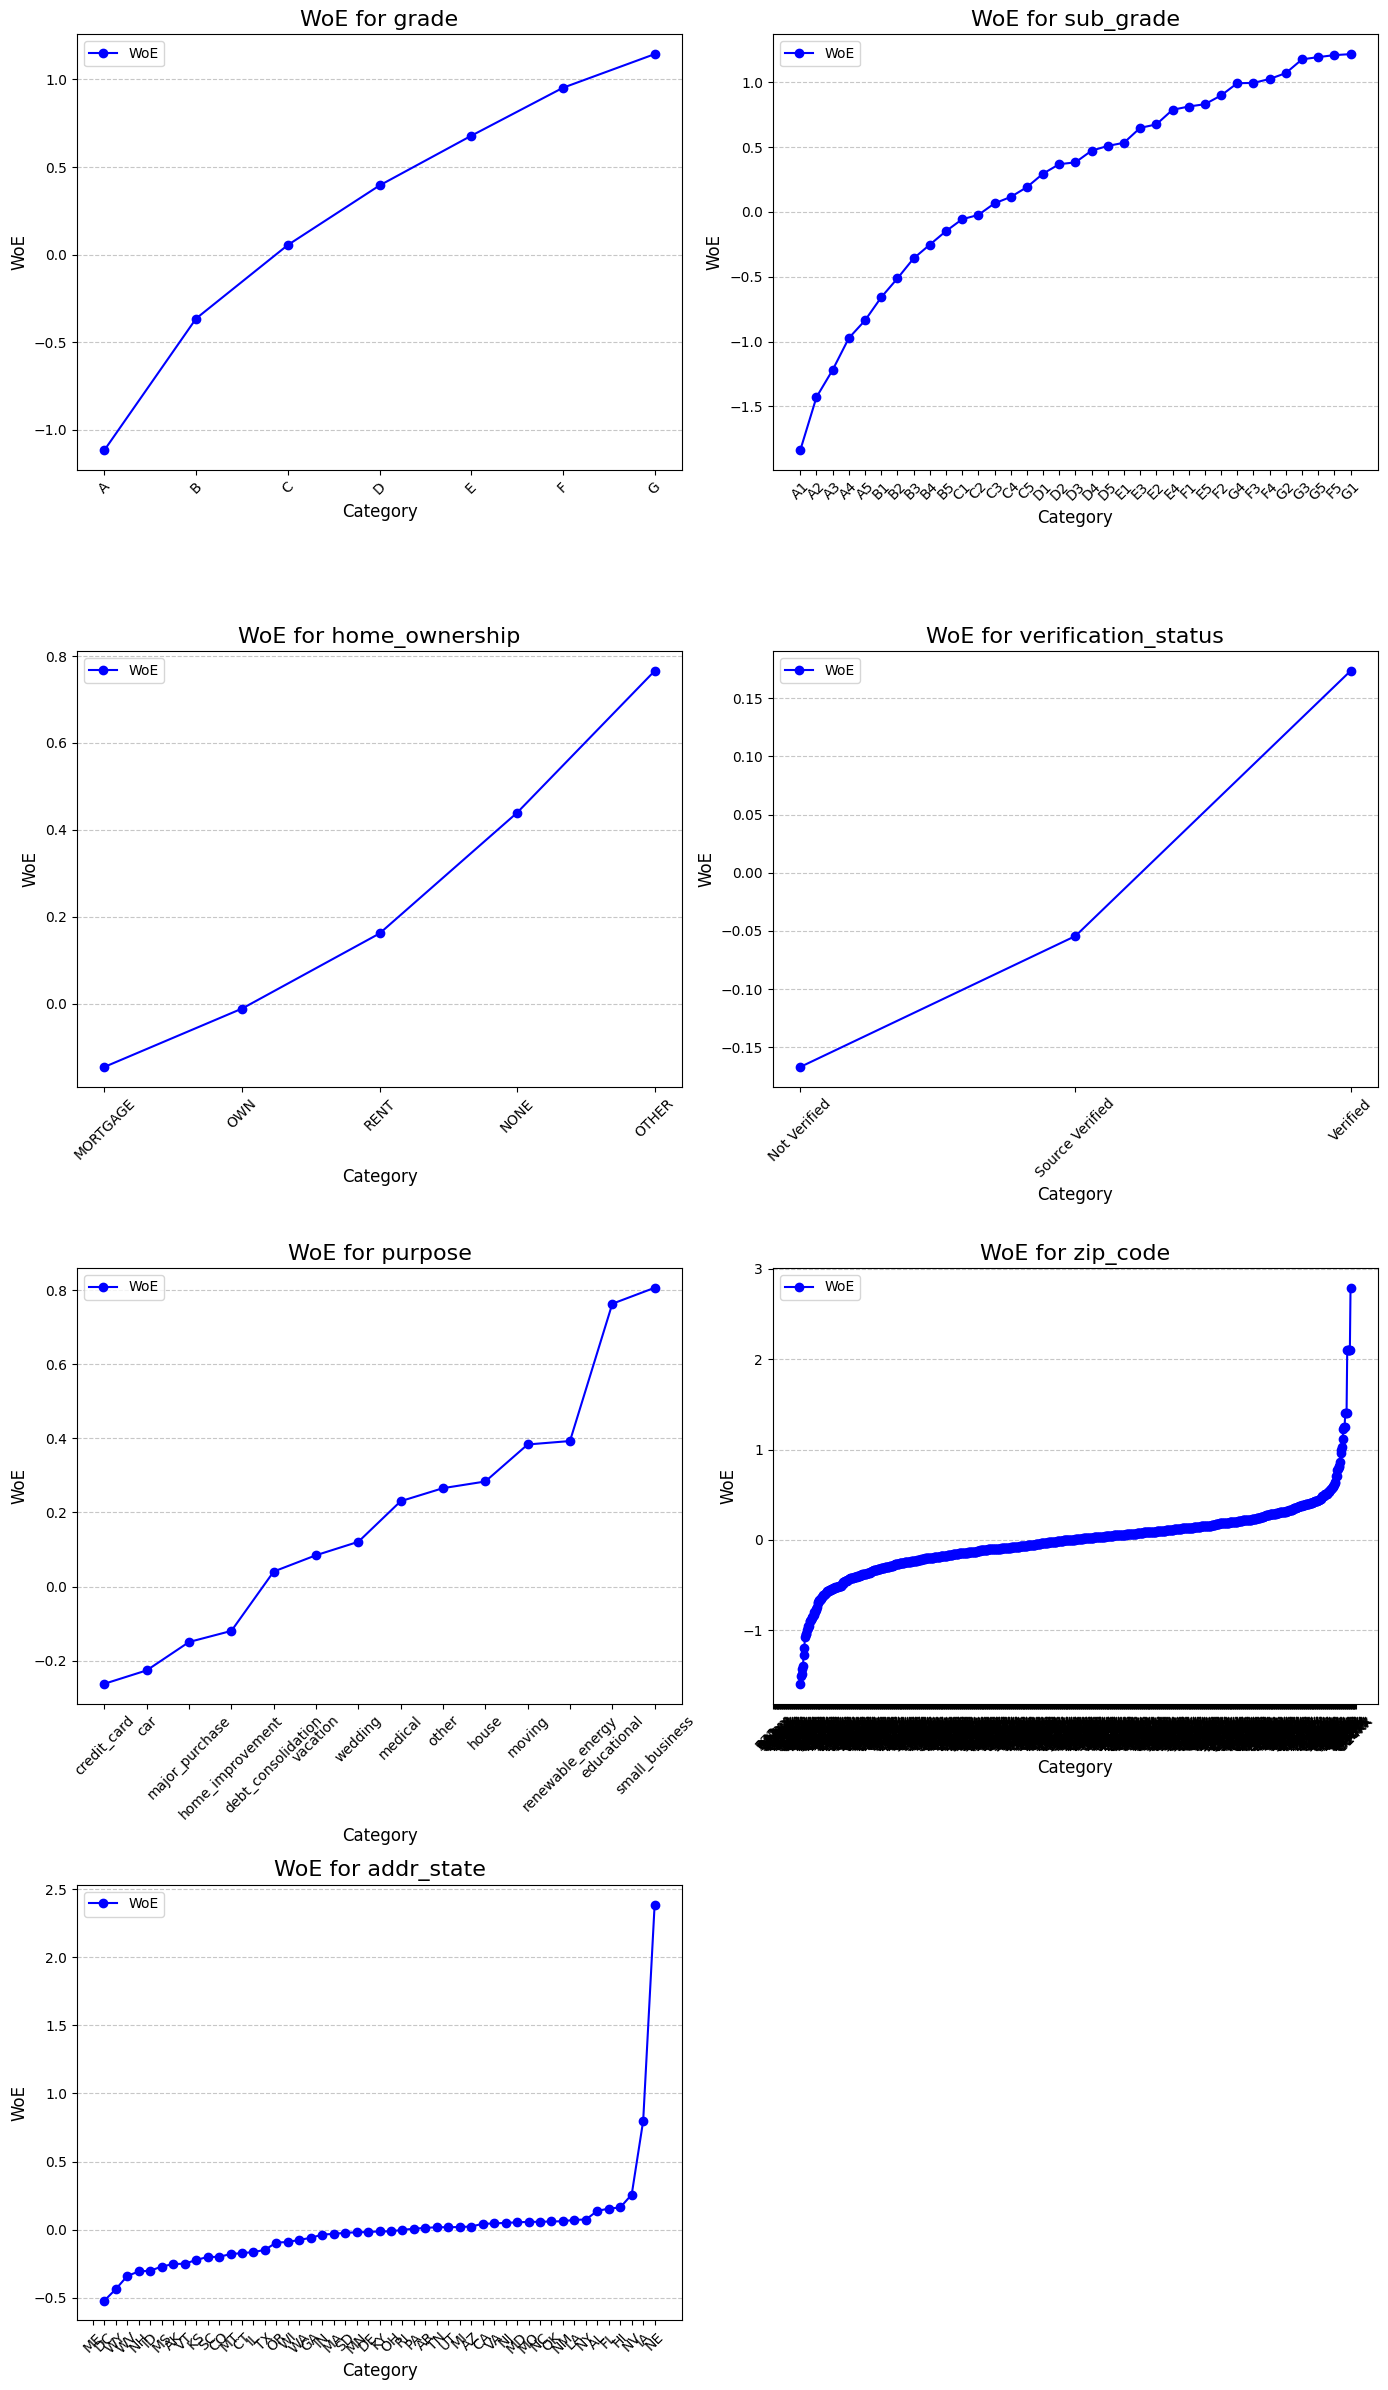

In [ ]:
def compute_woe(feature, target):
    feature_target_df = pd.crosstab(feature, target, normalize='columns')

    # Get the proportions of good (target == 0) and bad (target == 1) outcomes
    feature_target_df['good_dist'] = feature_target_df[0]
    feature_target_df['bad_dist'] = feature_target_df[1]

    # Compute WoE for each category
    feature_target_df['WoE'] = np.log(feature_target_df['good_dist'] / feature_target_df['bad_dist'])

    return feature_target_df[['good_dist', 'bad_dist', 'WoE']]

def plot_woe(features, df, target):
    """
    Plots Weight of Evidence (WoE) for a list of features, arranged in a 2-column grid.

    Parameters:
    - features: list of feature names (categorical variables).
    - df: pandas DataFrame containing the features and the target variable.
    - target: the target variable for binary classification.
    """
    # Calculate number of rows (2 columns per row)
    n_features = len(features)
    n_cols = 2
    n_rows = (n_features + 1) // n_cols

    # Create a figure with subplots in 2 columns
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(14, 6 * n_rows))
    axs = axs.flatten()  # Flatten to 1D to iterate easily

    for i, feature in enumerate(features):
        # Compute WoE for the current feature
        woe_df = compute_woe(df[feature], df[target])

        # Sort the WoE values to ensure an increasing line plot
        woe_df_sorted = woe_df.sort_values(by='WoE')

        # Plot WoE as a line plot for the feature
        axs[i].plot(woe_df_sorted.index, woe_df_sorted['WoE'], marker='o', linestyle='-', color='blue', label='WoE')
        axs[i].set_title(f'WoE for {feature}', fontsize=16)
        axs[i].set_xlabel('Category', fontsize=12)
        axs[i].set_ylabel('WoE', fontsize=12)
        axs[i].tick_params(axis='x', rotation=45)
        axs[i].grid(True, axis='y', linestyle='--', alpha=0.7)
        axs[i].legend()

    # Remove empty subplots if number of features is odd
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    # Adjust layout for better readability
    plt.tight_layout()
    plt.show()



plot_woe(categorical, df, 'status')

In [ ]:
# Check if each sub_grade corresponds to only one grade
mapping = df.groupby('sub_grade')['grade'].nunique()

# If all values are 1, grade is perfectly predictable from sub_grade
if (mapping == 1).all():
    print("Grade is perfectly predictable from sub_grade and may be redundant.")
else:
    print("Grade contains additional information.")

Grade is perfectly predictable from sub_grade and may be redundant.


In [ ]:
# Check if each sub_grade corresponds to only one grade
mapping = df.groupby('zip_code')['addr_state'].nunique()

# If all values are 1, grade is perfectly predictable from sub_grade
if (mapping == 1).all():
    print("Grade is perfectly predictable from sub_grade and may be redundant.")
else:
    print("Grade contains additional information.")

Grade contains additional information.


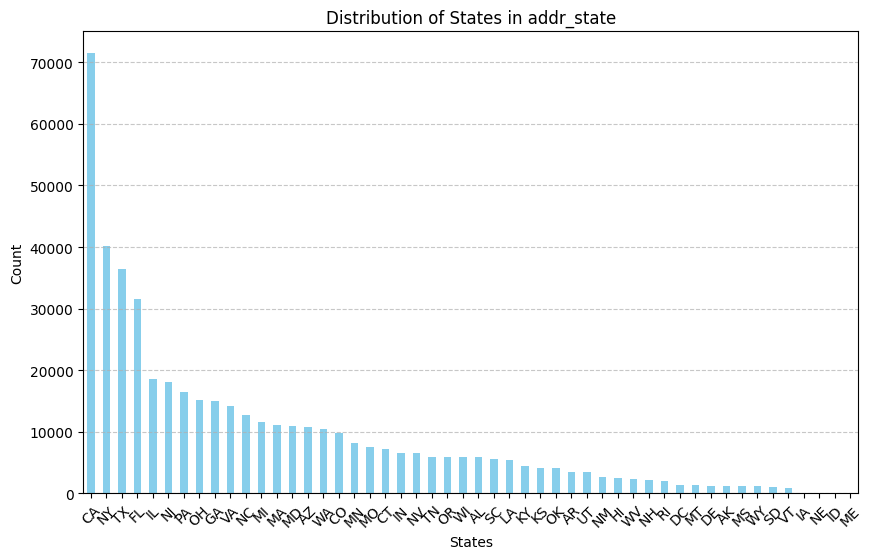

In [ ]:
state_counts = df['addr_state'].value_counts()
# state_counts = state_counts[state_counts<2000]

# Plotting the distribution
plt.figure(figsize=(10, 6))
state_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of States in addr_state')
plt.xlabel('States')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Verify whether high or low WoE values are influenced by the representation of states in the dataset

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


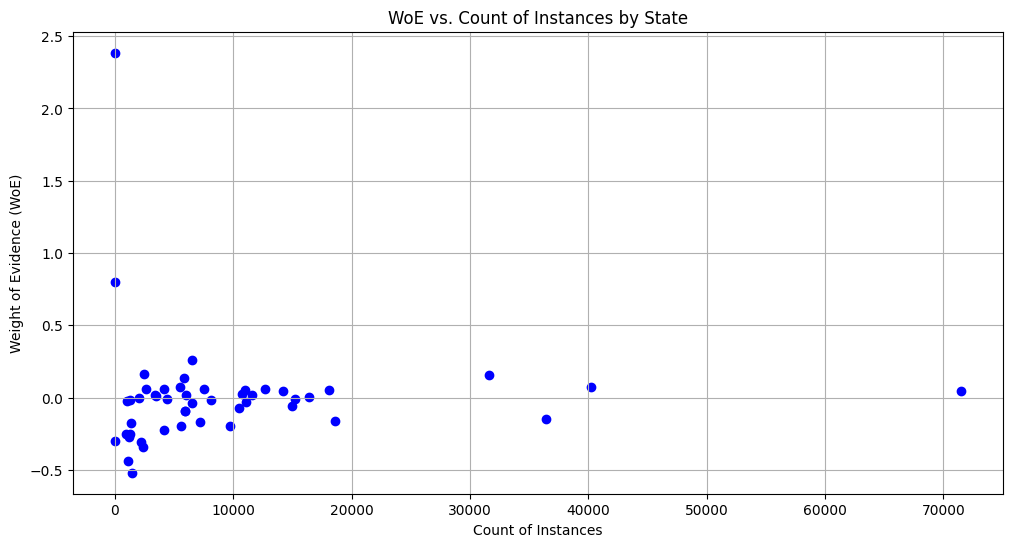

In [ ]:
woe_by_state = compute_woe(df['addr_state'], df['status'])
# Count instances per state
state_counts = df['addr_state'].value_counts().reset_index()
state_counts.columns = ['addr_state', 'count']

# Merge counts with WoE
woe_counts = woe_by_state.merge(state_counts, on='addr_state', how='left')

# Replace infinite values with NaN
woe_counts.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values in the WoE column
woe_counts.dropna(subset=['WoE'], inplace=True)


plt.figure(figsize=(12, 6))
plt.scatter(woe_counts['count'], woe_counts['WoE'], color='blue')
plt.title('WoE vs. Count of Instances by State')
plt.xlabel('Count of Instances')
plt.ylabel('Weight of Evidence (WoE)')
plt.grid()
plt.show()

We will drop zip_code, grade and recoveries columns. For zip_code, the column has high cardinality, is sensitive to population representation, and already addr_state provides and aggregate for it. The variable grade is redundant since sub_grade is a refinement of grade. As for the column recoveries, it provides  information we don't know when doing inference.

In [ ]:
df.drop(columns=['grade', 'zip_code', 'recoveries'], inplace=True)

In [ ]:
categorical = df.select_dtypes('O').columns.values
categorical

array(['sub_grade', 'home_ownership', 'verification_status', 'purpose',
       'addr_state'], dtype=object)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Separate features and target variable
X = df.drop('status', axis=1)  # Features
y = df['status']                # Target variable

# Convert categorical columns to 'category' dtype
for col in categorical:
    X[col] = X[col].astype('category')

# Replace infinite values with a large finite value
X.replace([np.inf, -np.inf], np.finfo(np.float32).max, inplace=True) # Added line to replace infinite values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Create and train the XGBoost model with categorical handling
model = xgb.XGBClassifier(use_label_encoder=False,
            eval_metric='logloss',
            scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
            enable_categorical=True)

model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:16:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.99
              precision    recall  f1-score   support

           0       0.98      0.95      0.96     10194
           1       0.99      1.00      1.00     83063

    accuracy                           0.99     93257
   macro avg       0.99      0.97      0.98     93257
weighted avg       0.99      0.99      0.99     93257



ROC AUC Score: 1.00


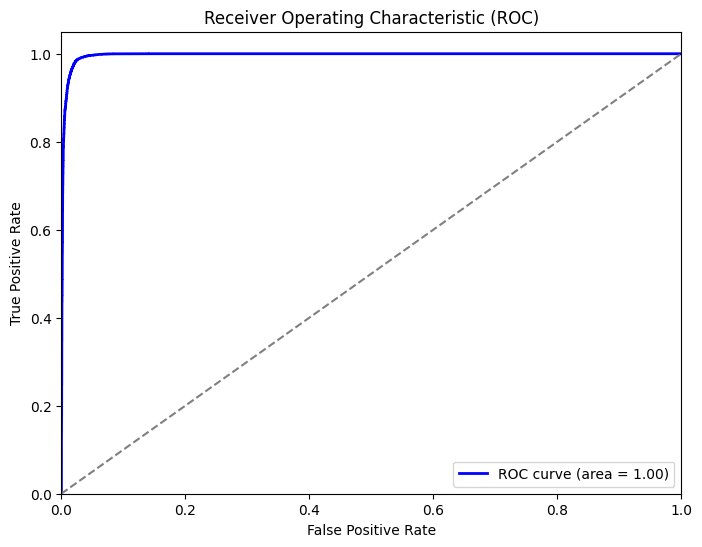

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Predict probabilities for the positive class
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC Score: {roc_auc:.2f}")

# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

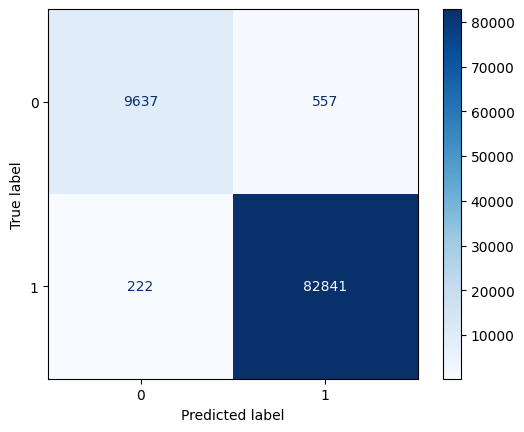

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.show()

# Feature importance

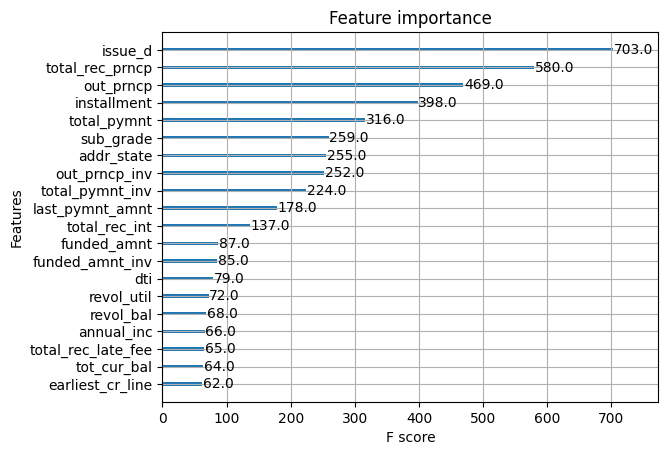

In [ ]:
# Plot feature importances
xgb.plot_importance(model, max_num_features=20)
plt.show()